# PELT integration test

Test the penalized exact linear time method for inferring changepoints. This is based on a PELT variant in which we minimize a cost function based on a KL divergence between the observed data distribution and a Bernoulli posterior for the latent state with piecewise-constant probability $p$.

## Load data

In [1]:
using HDF5

fid = h5open("data/basic_poisson_test.jld", "r")
λ = read(fid["base_rate"])
ν = read(fid["rate_gain"])
dt = read(fid["bin_width"])
counts = read(fid["counts"])
states = read(fid["states"]);

In [2]:
size(counts)

(1000,)

## Plot data

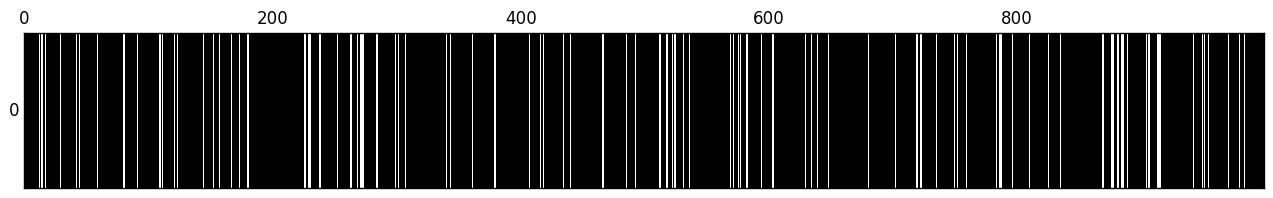

In [4]:
using PyPlot

matshow(reshape(counts, 1, length(counts)), cmap="gray", aspect="auto", clim=(0, 1));

# Define some useful functions

In [9]:
# given start and end times t1 and t2, get sufficient statistics 
# for data between them
function grab_ss(t1, t2)
    this_counts = slice(counts, t1:t2)
    (sum(this_counts), length(this_counts))::Tuple{Int64, Int64}
end

grab_ss (generic function with 1 method)

In [6]:
function κ(N::Int64, ℓ::Int64)
    (N * log(ν) - λ * dt * (ν - 1) * ℓ)::Float64
end

κ (generic function with 1 method)

In [7]:
function L(N::Int64, ℓ::Int64)
    kap = κ(N, ℓ)
    (kap + log1p(exp(-kap)))::Float64
end

L (generic function with 1 method)

In [8]:
function C(N::Int64, ℓ::Int64)
    kap = κ(N, ℓ)
    -kap / (1 + exp(-kap))
end

C (generic function with 1 method)

# Run inference

In [45]:
T = length(counts)  # number of time points
F = Array{Float64}(T + 1)  # F(t) = minimum cost for all data up to time t
R = Set{Int64}()  # set of times over which to search
CP = Set{Int64}()  # list of changepoints (ordered)
K = 0  # bound constant for objective gain on inserting changepoint

0

Now, initialize $F(0)$ and $R$:

In [46]:
push!(R, 0)
F[1] = 0

0

In [47]:
for τ in 1:T
    costs = Float64[F[t + 1] - L(grab_ss(t + 1, τ)...) for t in R]
    F[τ + 1] = minimum(costs)
    new_τ = indmin(costs) - 1
    push!(CP, new_τ)
    R = filter(t -> F[t + 1] + C(grab_ss(t + 1, τ)...) + K < F[τ + 1], R)
    push!(R, τ)
end

In [48]:
F[1:10]

10-element Array{Float64,1}:
  0.0    
 -1.31225
 -1.95664
 -2.60104
 -3.24544
 -3.88983
 -4.53423
 -5.17863
 -5.82302
 -6.46742

In [49]:
CP

Set([0])

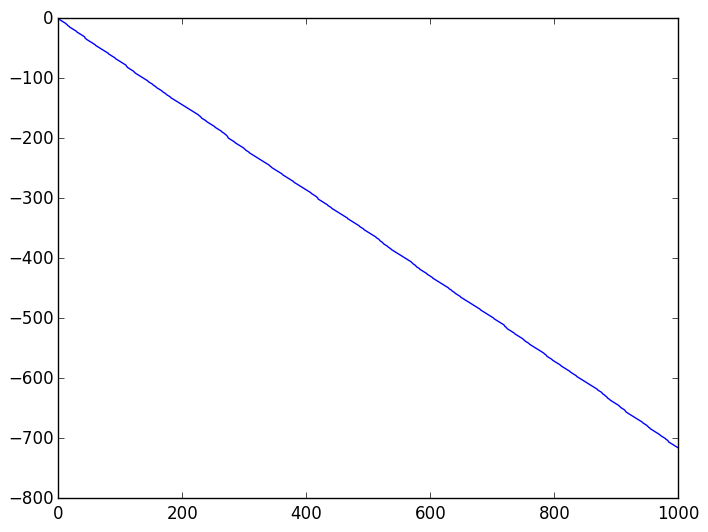

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f215ae0d750>

In [50]:
plot(F)